## TME - 5 Visualisation et Recommandation 

In [ ]:
from sklearn.datasets import fetch_mldata as ldata
from sklearn.cross_validation import train_test_split
from sklearn import datasets
from scipy.linalg import solve
from scipy.sparse import linalg, eye
from scipy import stats
from scipy.spatial import distance
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import random


## Exercice 1

### Question 1: Implémentez le modèle t-SNE

In [25]:

class TSNE():
    '''TSNE'''
    def __init__(self,perplexite, nIterations, lr, momentum, dimension):
        self.perp = perplexite
        self.nIter = nIterations
        self.moment = momentum
        self.dim = dimension
        self.lr = lr


    def fit_transform(self,data):
        nEx = np.shape(data)[0]
        # Matrice de distances de ||xi - xj||²
        normx = np.sum(data**2,1)
        normx = np.reshape(normx, (1, nEx))
        distancex = normx + normx.T - 2 * data.dot(data.T)
        # Ici on calcule les sigmas
        lperp = np.log2(self.perp)
        sup = np.ones((nEx,1)) * np.max(distancex)
        inf = np.zeros((nEx,1))
        self.sigma = (sup + inf) / 2.

        while True:
            # Calcul de la matrice des distances pour les paires p(i|j)
            self.pcond = np.exp(-distancex / (2. * (self.sigma**2)))
            self.pcond = self.pcond / np.sum(self.pcond - np.eye(nEx),1).reshape(nEx,1)
            # Calculer l'entropie de p(i|j)
            entropy = - np.sum(self.pcond * np.log2(self.pcond), 0)
            up = entropy < lperp
            inf[up,0] = self.sigma[up,0]
              # Si il faut baisser sigma
            down = entropy > lperp
            sup[down,0] = self.sigma[down,0]
            # Mise a jour de sigma et condition d'arrêt
            old = self.sigma
            self.sigma = ((sup + inf) / 2.)
            if np.max(np.abs(old - self.sigma)) < 1e-5:
                break

        #initialiser y
        self.embeddings = np.zeros((self.nIter+2, nEx, self.dim))
        self.embeddings[1] = np.random.randn(nEx, self.dim) * 1e-4
        # p(ij)
        self.pij = (self.pcond + self.pcond.T) / (2.*nEx)
        np.fill_diagonal(self.pij, 0)
        # Descente de Gradient
        loss = []
        for t in range(1,self.nIter+1):
            # Matrice des distances
            normy = np.sum((self.embeddings[t]**2),1)
            normy = np.reshape(normy, (1, nEx))
            distancey = normy + normy.T - 2 * self.embeddings[t].dot(self.embeddings[t].T)
            self.qij = 1 / (1 + distancey)
            np.fill_diagonal(self.qij, 0)
            self.qij = self.qij / self.qij.sum()
            yt = self.embeddings[t]
            tmpgrad = 4 * ((self.pij - self.qij) / (1 + distancey)).reshape(nEx, nEx,1)
            for i in range(nEx):
                dy = (tmpgrad[i] * (yt[i]-yt)).sum(0)
                self.embeddings[t+1][i] = yt[i] - self.lr * dy + self.moment * (yt[i] - self.embeddings[t-1,i])
            l = stats.entropy(self.pij, self.qij, 2).mean()
            loss.append(l)


        return self.embeddings[-1,:,:]

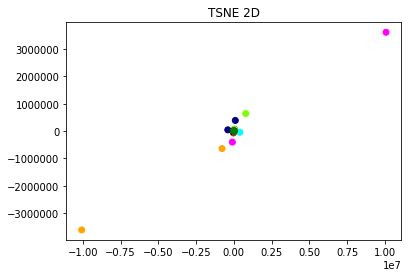

In [26]:
###Question 2: Construisez une visualisation 2D et 3D

#Visualisation2D:

def plot_embedding_2D(X,y,title):
    fig = plt.figure()
    labels = y
    colormap = np.array(['aqua', 'chartreuse', 'crimson', 'fuchsia', 'gold', 'orchid', 'orange', 'navy', 'green', 'black'])
    plt.scatter(X[:,0], X[:,1]  , c=colormap[labels])
    plt.title(title)
    plt.show()


def plot_embedding_3D(X,y):
    fig = plt.figure()
    ax=Axes3D(fig)
    labels = y
    colormap = np.array(['aqua', 'chartreuse', 'crimson', 'fuchsia', 'gold', 'orchid', 'orange', 'navy', 'green', 'black'])
    ax.scatter(X[:,0], X[:,1],X[:,2],c=colormap[labels])
    plt.title('TSNE 3D')
    plt.show()

#Chargement de la base MNIST ( hand written digits)
data = datasets.load_digits()

#Résultat du TSNE en 2D
TSNE_2D = TSNE(5,40,1000,0,2)
X_tsne = TSNE_2D.fit_transform(data.data)
plot_embedding_2D(X_tsne, data.target,"TSNE 2D")



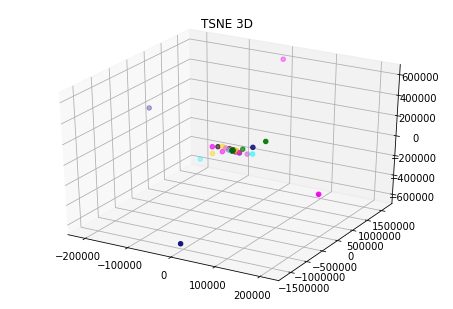

In [3]:
#Résultat du TSNE en 3D
TSNE_3D = TSNE(5,100,1000,0,3)
X_tsne = TSNE_3D.fit_transform(data.data)
plot_embedding_3D(X_tsne, data.target)

# Question 2 (suite) comparer avec des méthodes de réduction linéaires.
### PCA Pincipal Component Analisys

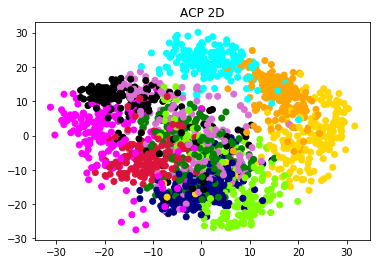

In [5]:
from sklearn.decomposition import PCA
clf=PCA(n_components=2)
X_ACP=clf.fit_transform(data.data)
plot_embedding_2D(X_ACP, data.target,"ACP 2D")


## Question 3 nous comparons avec des méthodes de réduction non linéaires.

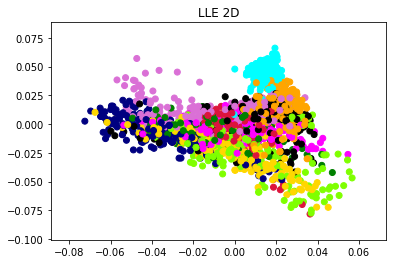

In [7]:
from sklearn import manifold

#LLE Locally Linear Embedding
clf=manifold.LocallyLinearEmbedding(n_neighbors=75,n_components=2,method="standard")
X_Lle=clf.fit_transform(data.data)
plot_embedding_2D(X_Lle, data.target,"LLE 2D")
#error=clf.reconstruction_error_

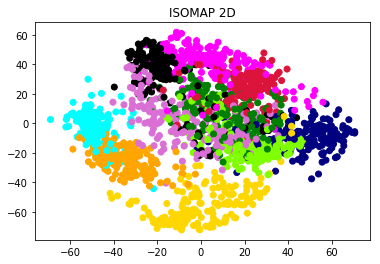

In [9]:
#ISOMAP
clf=manifold.Isomap(n_neighbors=75,n_components=2)
X_iso=clf.fit_transform(data.data)
plot_embedding_2D(X_iso, data.target,"ISOMAP 2D")


## Exercice 2
### Question 1

In [12]:
movie = pd.read_csv('/Users/melkigabriel/Downloads/ml-100k/u5.base',
                    sep='\t',
                    names =['user_id','item_id','rating','timestamp'])
movie.head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,4,3,876893119
3,1,5,3,889751712
4,1,6,5,887431973


In [17]:
#construisons la matrice de distance
from scipy.stats import pearsonr
t = pd.crosstab(movie['user_id'],  movie['item_id']) #Matrice de filtre, =1 s'il y a un rating, zero sinon

for i in range(len(movie)):
    t[int(movie[i:(i+1)]['item_id'])][int(movie[i:(i+1)]['user_id'])]=movie[i:(i+1)]['rating']

#t= t[t>0]    

pearson =np.zeros((943,943))
for i in range(0,943):
    for j in range(0,(i+1)):
        pearson[i][j]=pearsonr(t.ix[j+1,],t.ix[i+1,])[0]
        
pearson

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09203227,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00819144,  0.07850824,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.1455112 ,  0.0238058 ,  0.10302023, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.051966  ,  0.09773766,  0.06323295, ...,  0.06217893,
         1.        ,  0.        ],
       [ 0.18281859,  0.06450649,  0.00294718, ...,  0.1723851 ,
         0.05437645,  1.        ]])

5


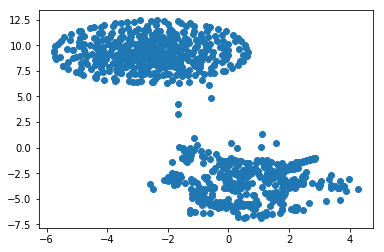

6


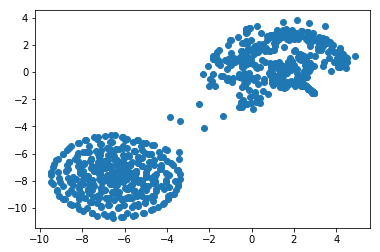

7


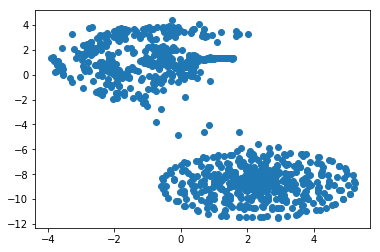

8


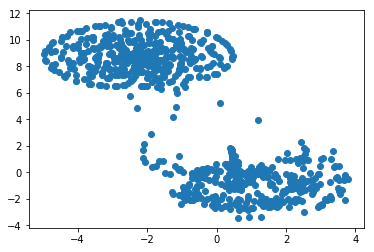

9


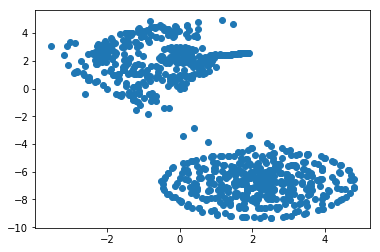

10


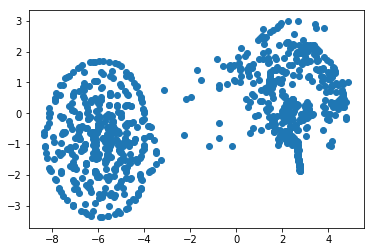

11


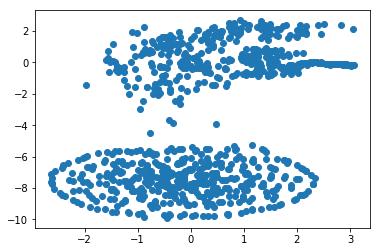

12


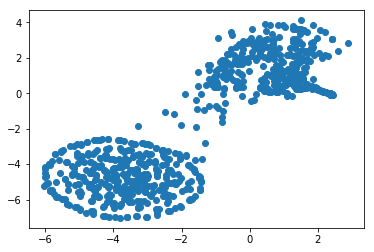

13


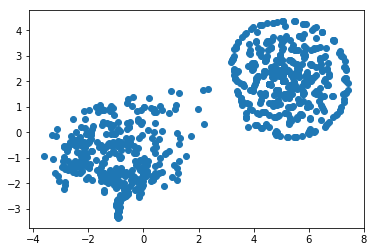

14


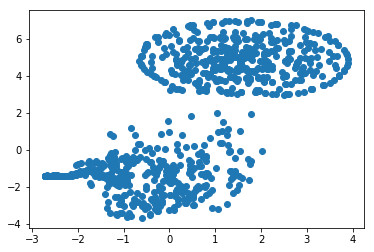

15


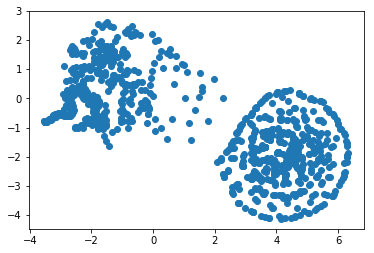

16


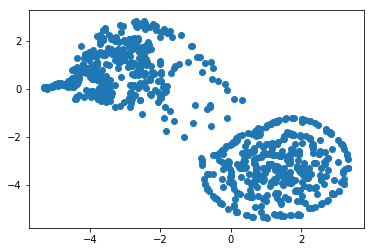

17


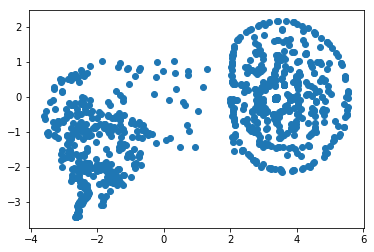

18


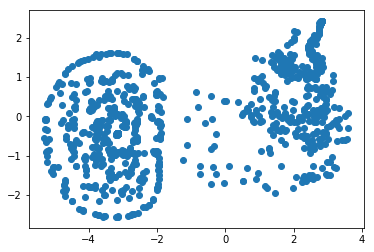

19


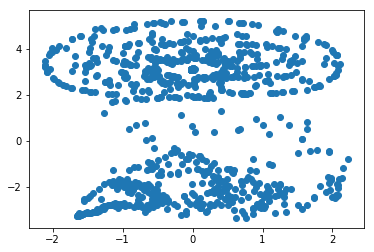

20


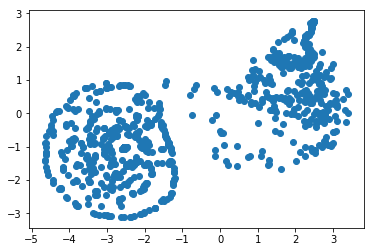

21


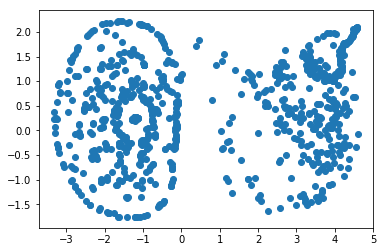

22


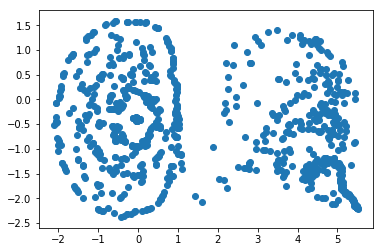

23


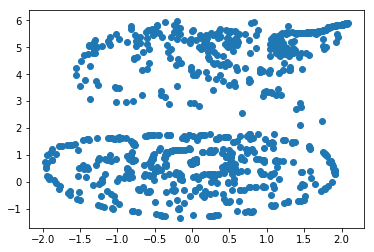

24


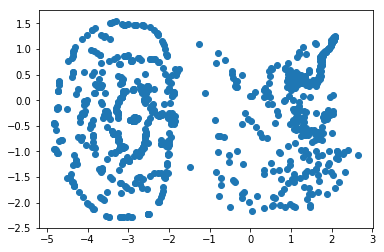

KeyboardInterrupt: 

In [32]:
from sklearn.manifold import TSNE
for i in range(5,50):
    movie_embedded = TSNE(n_components=2,perplexity=i,metric='precomputed').fit_transform(abs(pearson))
    plt.scatter(movie_embedded[:,0],movie_embedded[:,1])
    print(i)
    plt.show()

## Question 2

In [99]:
class CollaborativeFiltering(object):
    
    def __init__(self, dimFactorisation = 20, reg = 0.02, bias = False):
        """
        dimFactorisation : nouvelles dimensions des matrices
        reg : coefficient de regularisation
        bias : ajout de biais global/users/items
        """
        self.dimFactorisation = dimFactorisation
        self.loss_histo = []
        self.reg = reg
        self.bias = bias
        self.loss_histo = []
        
    def fit(self, users, items, ratings, nb_epochs = 10, learning_rate=0.001, verbose=False):
        #Initialisation des deux matrices U et V  (x = u*v)
        nbUsers = max(users)
        nbItems = max(items)
        # U est de dimensions K x NbUsers
        self.u = np.random.rand(self.dimFactorisation, nbUsers)
        #V est de dimensions NbItems x K
        self.v = np.random.rand(nbItems,self.dimFactorisation)
        #Initialisation eventuelle des biais
        if self.bias :
            self.usersBias = np.random.rand(nbUsers)
            self.itemsBias = np.random.rand(nbItems)
            self.globalBias = np.random.rand(1)[0]
        #Nombre de notes 
        nbRatings = len(ratings)
        for ep in range(nb_epochs):
            #SGD
            loss = 0
            for it in range(nbRatings):
                ratingIndex = np.random.randint(nbRatings) #Rating tire au hasard
                
                #Utilisateur/item  séléctionnés
                user = int(users[ratingIndex]) -1
                item = int(items[ratingIndex]) - 1
                rating = ratings[ratingIndex]
                
                #Estimation actuelle du rating
                prediction = self.u[:, user].dot(self.v[item,:])
                #Ajout eventuel des biais
                if self.bias : 
                    prediction += self.globalBias + self.usersBias[user] + self.itemsBias[item]
                
                diff = (rating - prediction)
                
                loss +=diff**2
                
                factor = 1-self.reg*learning_rate
                self.u[:,user] = factor * self.u[:,user] + learning_rate * self.v[item] * diff
                self.v[item,:] = factor * self.v[item,:] + learning_rate * self.u[:,user] * diff
                
                if self.bias:
                    self.usersBias[user] = factor * self.usersBias[user] + learning_rate * diff
                    self.itemsBias[item] = factor*self.itemsBias[item] + learning_rate * diff
                    self.globalBias = factor * self.globalBias + learning_rate * diff
            
            self.loss_histo.append(loss)
            if verbose :
                print("Loss on epoch %d : %f"%(ep, loss))
        print("Apprentissage du modele fini, loss final en train : %f"%(loss))
        
    def predict(self, userIds, itemIds):
        preds = np.array([int(self.u[:,user-1].dot(self.v[item-1])) for user, item in zip(userIds, itemIds)])
        return preds
        
    def score(self, userIds, itemIds, ratings):
        preds = self.predict(userIds, itemIds)
        return np.mean(preds.reshape(ratings.shape) == ratings)

## Question 3

In [101]:
user = np.array(movie['user_id'])
item = np.array(movie['item_id'])
ratings = np.array(movie['rating'])
timestamps = np.array(movie['timestamp'])

user_train, user_test, item_train, item_test, ratings_train, ratings_test = train_test_split(user, item, ratings, train_size=0.8)

cf = CollaborativeFiltering(bias=False)
cf.fit(user_train, item_train, ratings_train, nb_epochs=10)

cfBias = CollaborativeFiltering(bias=True)
cfBias.fit(user_train, item_train, ratings_train, nb_epochs=10)

#testons
print("L'erreur en test sans biais est de  "+str((1*cf.predict(user_test,item_test) == ratings_test).mean()))
print("L'erreur en test avec biais est de  "+str((1*cfBias.predict(user_test,item_test) == ratings_test).mean()))


Apprentissage du modele fini, loss final en train : 64064.084990
Apprentissage du modele fini, loss final en train : 59938.954059
L'erreur en test sans biais est de  0.31225
L'erreur en test avec biais est de  0.336375
